In [1]:
import wfdb
import numpy as np
import scipy as spy
import matplotlib.pyplot as plt

pat_id = 101

# Read a record from the database
record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')

In [3]:
# Find RR-intervals and min and max of each set
rr_intervals = []
for i in range(2, len(location)):
    rr_intervals.append(location[i]-location[i-1])

print(rr_intervals)
print(min(rr_intervals))
print(max(rr_intervals))

[313, 315, 321, 336, 344, 324, 313, 313, 310, 329, 330, 329, 323, 326, 319, 313, 328, 329, 325, 305, 302, 313, 320, 323, 319, 309, 307, 305, 295, 307, 325, 328, 309, 302, 293, 285, 290, 290, 288, 283, 290, 272, 274, 283, 290, 303, 307, 283, 272, 279, 286, 291, 300, 304, 301, 294, 282, 282, 285, 297, 291, 290, 290, 291, 302, 313, 320, 329, 344, 332, 310, 322, 321, 331, 344, 331, 317, 316, 314, 316, 320, 334, 330, 304, 302, 327, 330, 336, 318, 313, 309, 316, 302, 294, 312, 315, 306, 299, 301, 297, 325, 324, 313, 315, 303, 301, 299, 302, 310, 315, 299, 288, 301, 308, 310, 314, 305, 312, 308, 304, 309, 323, 326, 331, 318, 311, 317, 316, 321, 327, 263, 65, 216, 92, 289, 278, 286, 101, 196, 295, 293, 276, 278, 278, 270, 279, 292, 289, 301, 293, 283, 286, 299, 302, 310, 310, 299, 296, 289, 284, 289, 304, 304, 297, 277, 279, 270, 279, 289, 298, 286, 287, 278, 274, 273, 282, 293, 294, 286, 280, 274, 296, 297, 293, 298, 305, 301, 296, 300, 311, 334, 340, 336, 317, 297, 303, 321, 324, 332, 334, 3

In [4]:
# Read record numbers
with open('./data/mitdb/RECORDS') as f:
    records = f.readlines()

for i in range(0,len(records)):
    records[i] = int(records[i])
    

In [5]:
# Find RR-intervals for all records
# Check abnormally long/short intervals
rr_intervals = []
check = [] 
check_low = []

for id in records:
    pat_id = id
    annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
    location = annotation.sample
    for i in range(2, len(location)):
        if location[i]-location[i-1] > 1270:
            check.append(id)
        if location[i]-location[i-1] < 25:
            check_low.append(id)
        rr_intervals.append(location[i]-location[i-1])

(array([2.9400e+02, 1.8590e+03, 4.6440e+03, 1.5964e+04, 3.2821e+04,
        3.0903e+04, 1.4871e+04, 7.0300e+03, 2.9980e+03, 6.8800e+02,
        1.3700e+02, 6.6000e+01, 1.0900e+02, 5.6000e+01, 1.2000e+01,
        8.0000e+00, 1.0000e+01, 1.8000e+01, 2.2000e+01, 6.0000e+00,
        6.0000e+00, 9.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   6. ,   58.7,  111.4,  164.1,  216.8,  269.5,  322.2,  374.9,
         427.6,  480.3,  533. ,  585.7,  638.4,  691.1,  743.8,  796.5,
         849.2,  901.9,  954.6, 1007.3, 1060. , 1112.7, 1165.4, 1218.1,
        1270.8, 1323.5, 1376.2, 1428.9, 1481.6, 1534.3, 1587. , 1639.7,
        1692.4, 1745.1, 1797.8, 1850.5, 1903.2, 1955.9, 2008.6, 2061.3,
        2114. ]),
 <BarContainer object of 40 artists>)

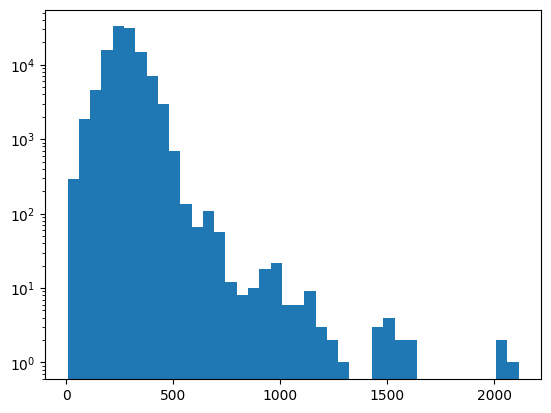

In [6]:
# Plot distribution of RR-intervals
plt.hist(rr_intervals, bins=40, log=True)

In [7]:
# Read annotations
annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')
loc = annotation.sample
beat_type = annotation.symbol
signal = record.p_signal[:,0]
set(beat_type)


{'+', 'J', 'N', 'V', '~'}

In [28]:
# Segment by using relative minimum RR-interval
segments = []
beat_types = []

classes = {0:'N',1:'S',2:'V',3:'F',4:'Q'}
reduced = {'N':['N','L','R','e','j'],
                 'S':['S','A','a','J'],'V':['V','E'],'F':['F'],'Q':['/','Q','f']}

valid_types = ['N','L','R','e','j','S','A','a','J','V','E','/','Q','f']

reverse_reduced = {value: key for key, values in reduced.items() for value in values}

108264


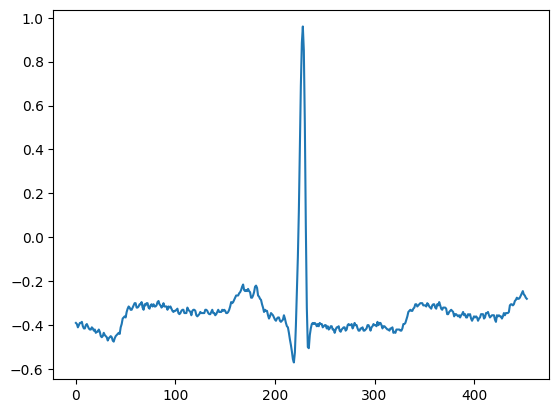

In [29]:
for id in records:
    pat_id = id
    annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
    record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')
    loc = annotation.sample
    beat_type = annotation.symbol
    signal = record.p_signal[:,0]

    for i in range(2, len(loc)-1):
        if beat_type[i] not in valid_types:
            continue
        
        dist = round(min(loc[i]-loc[i-1], loc[i+1]-loc[i])*0.8)
        if dist * 2 < 100 or dist * 2 > 1000:
            continue

        segments.append(signal[loc[i]-dist:loc[i]+dist])
        beat_types.append(reverse_reduced[beat_type[i]])

print(len(segments))
plt.plot(segments[1])


966
102251
N
N
S


(array([3.180e+02, 2.860e+02, 5.910e+02, 4.910e+02, 1.009e+03, 1.782e+03,
        2.118e+03, 2.641e+03, 4.347e+03, 6.965e+03, 5.412e+03, 4.915e+03,
        8.572e+03, 9.049e+03, 1.051e+04, 6.959e+03, 7.836e+03, 7.898e+03,
        6.456e+03, 4.061e+03, 3.296e+03, 3.168e+03, 2.324e+03, 1.599e+03,
        1.305e+03, 1.502e+03, 1.620e+03, 6.600e+02, 2.690e+02, 1.330e+02,
        7.800e+01, 4.200e+01, 2.200e+01, 1.000e+01, 6.000e+00, 6.000e+00,
        1.000e+00, 3.000e+00, 3.000e+00, 1.000e+00]),
 array([100.  , 121.65, 143.3 , 164.95, 186.6 , 208.25, 229.9 , 251.55,
        273.2 , 294.85, 316.5 , 338.15, 359.8 , 381.45, 403.1 , 424.75,
        446.4 , 468.05, 489.7 , 511.35, 533.  , 554.65, 576.3 , 597.95,
        619.6 , 641.25, 662.9 , 684.55, 706.2 , 727.85, 749.5 , 771.15,
        792.8 , 814.45, 836.1 , 857.75, 879.4 , 901.05, 922.7 , 944.35,
        966.  ]),
 <BarContainer object of 40 artists>)

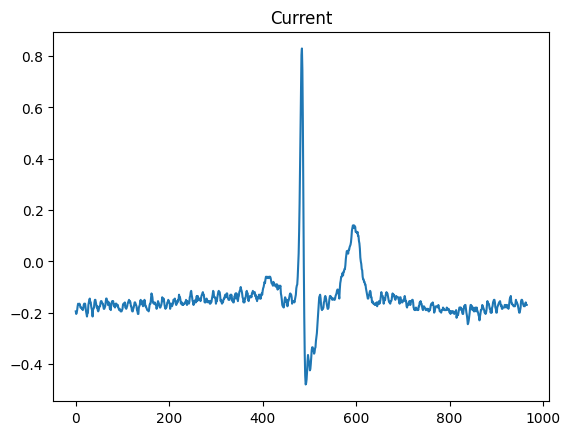

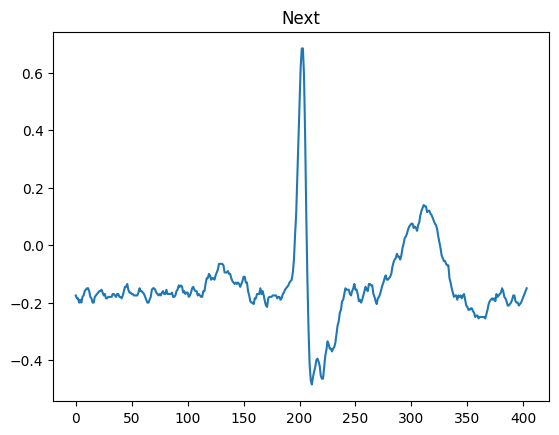

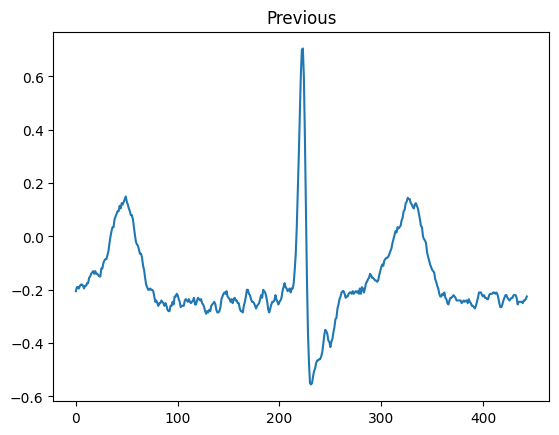

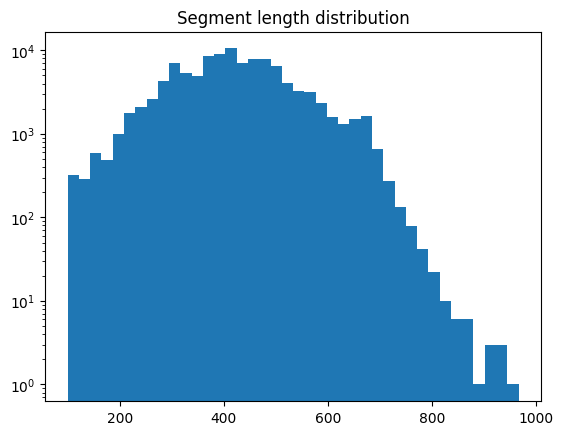

In [34]:
# Find min and max segment lengths
lengths = []
for segment in segments:
    lengths.append(len(segment))

# value = min(lengths)
value = max(lengths)
index = lengths.index(value)

print(value)
print(index-1)
print(beat_types[index])
print(beat_types[index+1])
print(beat_types[index-1])
plt.figure()
plt.title('Current')
plt.plot(segments[index])
plt.figure()
plt.title('Next')
plt.plot(segments[index+1])
plt.figure()
plt.title('Previous')
plt.plot(segments[index-1])

plt.figure()
plt.title('Segment length distribution')
plt.hist(lengths, bins=40, log=True)


In [13]:
# Toggle on/off
# Pre-CWT right side zero padding
max_len = len(segments[0])

for segment in segments:
    max_len = max(len(segment), max_len)

for i in range(0, len(segments)):
    arr = np.zeros(max_len - len(segments[i]))
    segments[i] = np.concatenate((segments[i], arr))

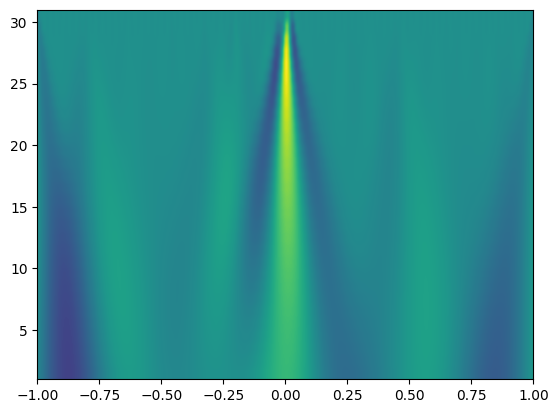

In [35]:
# Plot single continuous wavelet transform
widths = np.arange(1, 31)
cwtmatr = spy.signal.cwt(segments[1], spy.signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='viridis', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()